In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [2]:
from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaaf

In [3]:
from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os

In [4]:
IMG_DIR = './'
JSON = 'animal.json'
KEYPOINT_DEF = pd.read_csv('keypoint_def.csv')

In [5]:
KEYPOINT_DEF

,Unnamed: 0,Index,Name,Hex colour,Stanford,Animal-pose,(name in animal pose)
0,0,0,L_eye,d82400,y,n,NaN
1,1,1,R_eye,d82400,y,n,NaN
2,2,2,L_ear,fcfc00,y,n,NaN
3,3,3,R_ear,fcfc00,y,n,NaN
4,4,4,Nose,d848ff,y,n,NaN
5,5,5,Throat,fc90aa,y,n,NaN
6,6,6,Tail,48b455,y,n,NaN
7,7,7,withers,48b455,y,n,NaN
8,8,8,L_F_elbow,0090aa,y,n,NaN
9,9,9,R_F_elbow,0090aa,y,n,NaN


In [6]:
with open(JSON) as infile:
    json_dict = json.load(infile)

In [7]:
json_dict

{'img/379.jpeg': {'img_bbox': [0.2109887820808927,
   0.0,
   0.4351535180044172,
   0.9855023543837058],
  'img_path': 'img/379.jpeg',
  'joints': [[0.4805112310163247, 0.2913521572751191, 1],
   [0.360112841159538, 0.2907765182627944, 1],
   [0.5267765382805687, 0.1002836675676271, 1],
   [0.294249794769488, 0.1189037635332773, 1],
   [0.4147884863124794, 0.4041189324668792, 1],
   [0.4061251445150698, 0.5391189611948429, 1],
   [0.0, 0.0, 0],
   [0.0, 0.0, 0],
   [0.512857125151013, 0.5823372158079012, 1],
   [0.3500021260166167, 0.5736839424980911, 1],
   [0.0, 0.0, 0],
   [0.0, 0.0, 0],
   [0.4685929203481839, 0.620151080364877, 1],
   [0.3074416361854398, 0.625374274754931, 1],
   [0.0, 0.0, 0],
   [0.0, 0.0, 0],
   [0.4038290749881612, 0.6708158145459003, 1],
   [0.257224910007119, 0.6963160782984219, 1],
   [0.0, 0.0, 0],
   [0.0, 0.0, 0]]},
 'img/380.jpeg': {'img_bbox': [0.1566666666666666,
   0.05,
   0.7066666666666667,
   0.89],
  'img_path': 'img/380.jpeg',
  'joints': [[0

In [8]:
colours = KEYPOINT_DEF["Hex colour"].values.tolist()
colours = ["#" + colour for colour in colours]
labels = KEYPOINT_DEF["Name"].values.tolist()

In [9]:
def get_dog(name):
    data = json_dict[name]
    img_data = plt.imread(os.path.join(IMG_DIR, data["img_path"]))
    # If the image is RGBA convert it to RGB.
    if img_data.shape[-1] == 4:
        img_data = img_data.astype(np.uint8)
        img_data = Image.fromarray(img_data)
        img_data = np.array(img_data.convert("RGB"))
    data["img_data"] = img_data

    return data

In [10]:
def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x], [kp.y], c=colours[idx], marker="x", s=50, linewidths=5
                )
        else:
            current_keypoint = np.array(current_keypoint)
            # Since the last entry is the visibility flag, we discard it.
            current_keypoint = current_keypoint[:, :2]
            for idx, (x, y) in enumerate(current_keypoint):
                ax_all.scatter([x], [y], c=colours[idx], marker="x", s=50, linewidths=5)

    plt.tight_layout(pad=2.0)
    plt.show()

In [11]:
samples = list(json_dict.keys())
num_samples = 4
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

In [12]:
for sample in selected_samples:
    data = get_dog(sample)
    image = data["img_data"]
    keypoint = data["joints"]
    h, w, c = image.shape
    print(h,w,c)
    for i in keypoint:
        i[0]=i[0]*w
        i[1]=i[1]*h
    images.append(image)
    keypoints.append(keypoint)

239 300 3
300 300 3
188 300 3
195 300 3


In [13]:
keypoints

[[[66.0, 53.999999999999986, 0],
  [0.0, 0.0, 0],
  [96.0, 45.99999999999999, 1],
  [0.0, 0.0, 0],
  [30.0, 65.99999999999999, 1],
  [78.0, 105.0, 1],
  [201.0, 76.0, 1],
  [123.99999999999999, 86.99999999999999, 1],
  [118.99999999999999, 165.0, 1],
  [96.0, 158.0, 1],
  [210.0, 142.0, 1],
  [164.0, 145.0, 1],
  [115.99999999999999, 201.0, 1],
  [104.0, 189.0, 1],
  [214.0, 170.0, 1],
  [174.0, 167.0, 1],
  [107.0, 226.00000000000003, 1],
  [93.99999999999999, 212.0, 1],
  [214.0, 196.0, 1],
  [169.0, 189.0, 1]],
 [[195.0, 55.99999999999998, 1],
  [178.0, 58.99999999999998, 1],
  [0.0, 0.0, 0],
  [146.0, 54.999999999999986, 1],
  [210.0, 73.99999999999997, 1],
  [161.0, 114.99999999999999, 1],
  [0.0, 0.0, 0],
  [0.0, 0.0, 0],
  [179.0, 166.0, 1],
  [130.99999999999997, 160.0, 1],
  [215.0, 157.99999999999997, 1],
  [191.0, 167.0, 1],
  [169.0, 215.0, 1],
  [138.0, 206.99999999999997, 1],
  [214.0, 196.0, 1],
  [198.0, 188.0, 1],
  [163.0, 242.0, 1],
  [140.0, 225.0, 1],
  [210.0, 217

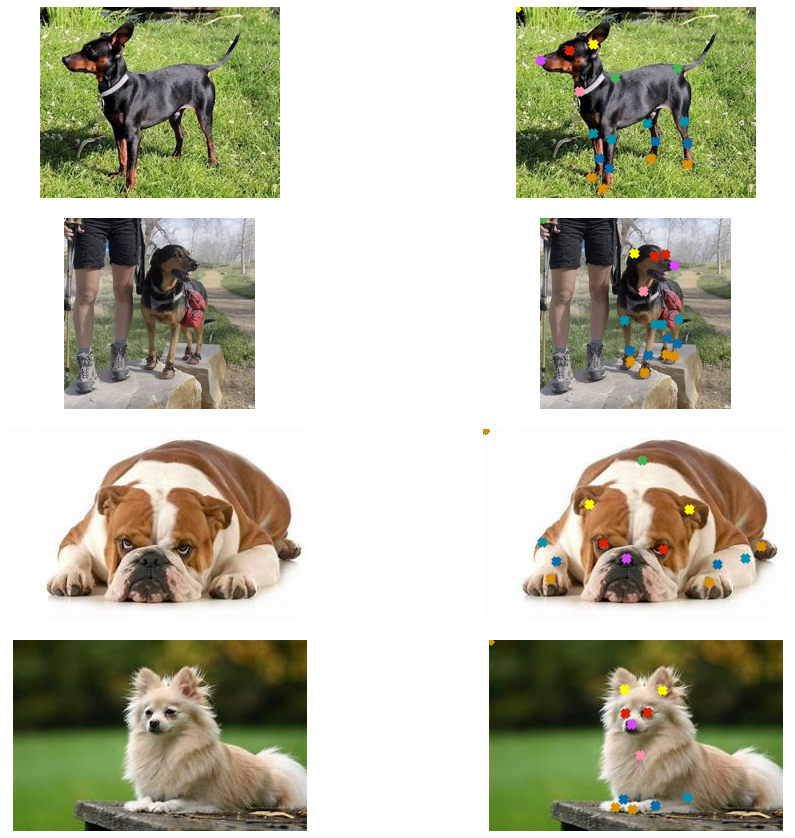

In [14]:
visualize_keypoints(images, keypoints)